In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# ===============================
# Script 1: Setup + Model A train
# ===============================
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import pandas as pd
import matplotlib.pyplot as plt

# ------------- Reproducibility -------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------- Data (Fashion-MNIST) -------------
transform = transforms.ToTensor()

data_root = "./data"
os.makedirs(data_root, exist_ok=True)

train_dataset = datasets.FashionMNIST(
    root=data_root, train=True, download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root=data_root, train=False, download=True, transform=transform
)

batch_size = 128

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)
val_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

# ------------- Model A: Simple MLP -------------
class MLPModelA(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        return self.net(x)

model_a = MLPModelA().to(device)
print(model_a)

criterion = nn.CrossEntropyLoss()
optimizer_a = optim.SGD(model_a.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10  # you can increase if you want

results_a = []

def run_one_epoch(model, loader, optimizer=None):
    """
    If optimizer is provided -> training mode.
    If optimizer is None -> evaluation mode.
    Returns: avg_loss, accuracy
    """
    if optimizer is not None:
        model.train()
    else:
        model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        if optimizer is not None:
            optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        if optimizer is not None:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

print("Training Model A (MLP)...")
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = run_one_epoch(model_a, train_loader, optimizer_a)
    val_loss, val_acc = run_one_epoch(model_a, val_loader, optimizer=None)

    results_a.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })

    print(
        f"[Model A] Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

# Save metrics & model
df_a = pd.DataFrame(results_a)
df_a.to_csv("results_model_a.csv", index=False)
torch.save(model_a.state_dict(), "model_a.pth")

print("\nSaved Model A metrics to results_model_a.csv and weights to model_a.pth")


Using device: cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.12MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.1MB/s]


MLPModelA(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)
Training Model A (MLP)...
[Model A] Epoch 01 | Train Loss: 0.8532, Train Acc: 0.7075 | Val Loss: 0.5336, Val Acc: 0.8105
[Model A] Epoch 02 | Train Loss: 0.4811, Train Acc: 0.8307 | Val Loss: 0.4911, Val Acc: 0.8204
[Model A] Epoch 03 | Train Loss: 0.4266, Train Acc: 0.8490 | Val Loss: 0.4318, Val Acc: 0.8445
[Model A] Epoch 04 | Train Loss: 0.3956, Train Acc: 0.8588 | Val Loss: 0.4403, Val Acc: 0.8390
[Model A] Epoch 05 | Train Loss: 0.3684, Train Acc: 0.8665 | Val Loss: 0.3986, Val Acc: 0.8560
[Model A] Epoch 06 | Train Loss: 0.3490, Train Acc: 0.8747 | Val Loss: 0.3745, Val Acc: 0.8625
[Model A] Epoch 07 | Train Loss: 0.3313, Train Acc: 0.8803 | Val Loss: 0.3731, Val Acc: 0.8674
[Model A] Ep

In [3]:
# ===============================
# Script 2: Model B train (better)
# ===============================
# Reuse: device, train_loader, val_loader, criterion from previous cell

class CNNModelB(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 28x28 -> 14x14

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 14x14 -> 7x7

            nn.Dropout(0.25),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model_b = CNNModelB().to(device)
print(model_b)

optimizer_b = optim.SGD(model_b.parameters(), lr=0.01, momentum=0.9)

num_epochs_b = 10  # keep same as Model A for fair comparison

results_b = []

print("Training Model B (CNN)...")
for epoch in range(1, num_epochs_b + 1):
    train_loss, train_acc = run_one_epoch(model_b, train_loader, optimizer_b)
    val_loss, val_acc = run_one_epoch(model_b, val_loader, optimizer=None)

    results_b.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })

    print(
        f"[Model B] Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

# Save metrics & model
df_b = pd.DataFrame(results_b)
df_b.to_csv("results_model_b.csv", index=False)
torch.save(model_b.state_dict(), "model_b.pth")

print("\nSaved Model B metrics to results_model_b.csv and weights to model_b.pth")


CNNModelB(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)
Training Model B (CNN)...
[Model B] Epoch 01 | Train Loss: 0.5438, Train Acc: 0.8042 | Val Loss: 0.3530, Val Acc: 0.8710
[Model B] Epoch 

Model A metrics (head):


,epoch,train_loss,train_acc,val_loss,val_acc
0,1,0.853163,0.707467,0.533582,0.8105
1,2,0.481081,0.830667,0.491107,0.8204
2,3,0.426637,0.848983,0.431849,0.8445
3,4,0.395606,0.858750,0.440292,0.8390
4,5,0.368411,0.866517,0.398575,0.8560


Model B metrics (head):


,epoch,train_loss,train_acc,val_loss,val_acc
0,1,0.543754,0.804200,0.353042,0.8710
1,2,0.381344,0.862517,0.301188,0.8894
2,3,0.335406,0.879067,0.283581,0.8955
3,4,0.310305,0.887167,0.289798,0.8932
4,5,0.294204,0.893717,0.265919,0.9010


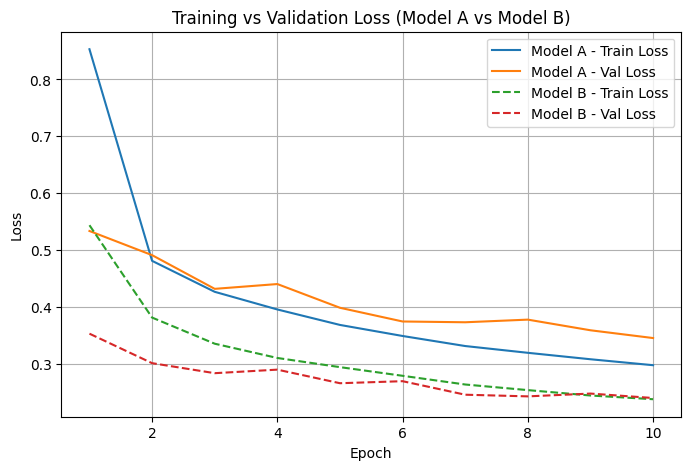

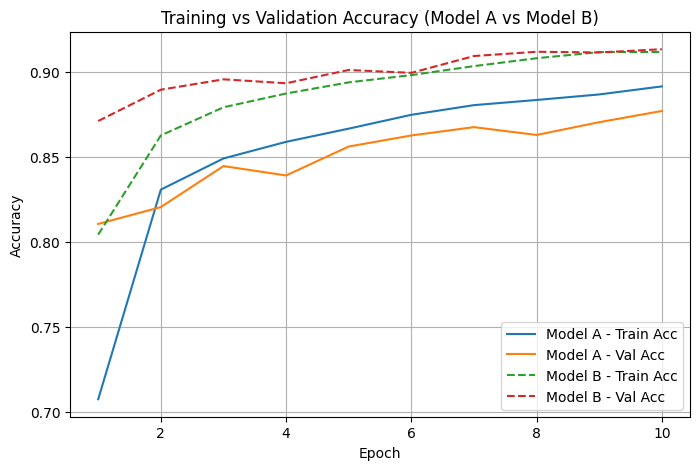


=== Final Epoch Summary ===
Model A - Train Loss: 0.2976, Train Acc: 0.8913
Model A - Val Loss  : 0.3453, Val Acc  : 0.8769
Model B - Train Loss: 0.2378, Train Acc: 0.9116
Model B - Val Loss  : 0.2399, Val Acc  : 0.9132

=== Generalization Gap (Train Acc - Val Acc) ===
Model A Gap: 0.0144
Model B Gap: -0.0016

=== High-level Interpretation (you can paraphrase this) ===
Model B reaches higher validation accuracy than Model A,
suggesting that the improved architecture leads to better generalization.
Model B also has a smaller gap between train and validation accuracy,
which is consistent with a more robust / 'flatter' solution in an intuitive sense.


In [4]:
# ===============================
# Script 3: Analysis & Plots
# ===============================
import pandas as pd
import matplotlib.pyplot as plt

df_a = pd.read_csv("results_model_a.csv")
df_b = pd.read_csv("results_model_b.csv")

print("Model A metrics (head):")
display(df_a.head())

print("Model B metrics (head):")
display(df_b.head())

# --------- 1. Loss curves ----------
plt.figure(figsize=(8, 5))
plt.plot(df_a["epoch"], df_a["train_loss"], label="Model A - Train Loss")
plt.plot(df_a["epoch"], df_a["val_loss"], label="Model A - Val Loss")
plt.plot(df_b["epoch"], df_b["train_loss"], label="Model B - Train Loss", linestyle="--")
plt.plot(df_b["epoch"], df_b["val_loss"], label="Model B - Val Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Model A vs Model B)")
plt.legend()
plt.grid(True)
plt.show()

# --------- 2. Accuracy curves ----------
plt.figure(figsize=(8, 5))
plt.plot(df_a["epoch"], df_a["train_acc"], label="Model A - Train Acc")
plt.plot(df_a["epoch"], df_a["val_acc"], label="Model A - Val Acc")
plt.plot(df_b["epoch"], df_b["train_acc"], label="Model B - Train Acc", linestyle="--")
plt.plot(df_b["epoch"], df_b["val_acc"], label="Model B - Val Acc", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (Model A vs Model B)")
plt.legend()
plt.grid(True)
plt.show()

# --------- 3. Final numbers & simple gaps ----------
final_a = df_a.iloc[-1]
final_b = df_b.iloc[-1]

print("\n=== Final Epoch Summary ===")
print(f"Model A - Train Loss: {final_a['train_loss']:.4f}, Train Acc: {final_a['train_acc']:.4f}")
print(f"Model A - Val Loss  : {final_a['val_loss']:.4f}, Val Acc  : {final_a['val_acc']:.4f}")
print(f"Model B - Train Loss: {final_b['train_loss']:.4f}, Train Acc: {final_b['train_acc']:.4f}")
print(f"Model B - Val Loss  : {final_b['val_loss']:.4f}, Val Acc  : {final_b['val_acc']:.4f}")

gap_a = final_a["train_acc"] - final_a["val_acc"]
gap_b = final_b["train_acc"] - final_b["val_acc"]

print("\n=== Generalization Gap (Train Acc - Val Acc) ===")
print(f"Model A Gap: {gap_a:.4f}")
print(f"Model B Gap: {gap_b:.4f}")

# A couple of human-readable lines you can adapt directly in the report:
print("\n=== High-level Interpretation (you can paraphrase this) ===")
if final_b["val_acc"] > final_a["val_acc"]:
    print("Model B reaches higher validation accuracy than Model A,")
    print("suggesting that the improved architecture leads to better generalization.")
else:
    print("Model A and Model B reach similar validation accuracy in this run.")

if gap_b < gap_a:
    print("Model B also has a smaller gap between train and validation accuracy,")
    print("which is consistent with a more robust / 'flatter' solution in an intuitive sense.")
else:
    print("The generalization gaps are similar; you can still compare convergence speed and stability.")


Model A metrics (head):


,epoch,train_loss,train_acc,val_loss,val_acc
0,1,0.853163,0.707467,0.533582,0.8105
1,2,0.481081,0.830667,0.491107,0.8204
2,3,0.426637,0.848983,0.431849,0.8445
3,4,0.395606,0.858750,0.440292,0.8390
4,5,0.368411,0.866517,0.398575,0.8560


Model B metrics (head):


,epoch,train_loss,train_acc,val_loss,val_acc
0,1,0.543754,0.804200,0.353042,0.8710
1,2,0.381344,0.862517,0.301188,0.8894
2,3,0.335406,0.879067,0.283581,0.8955
3,4,0.310305,0.887167,0.289798,0.8932
4,5,0.294204,0.893717,0.265919,0.9010


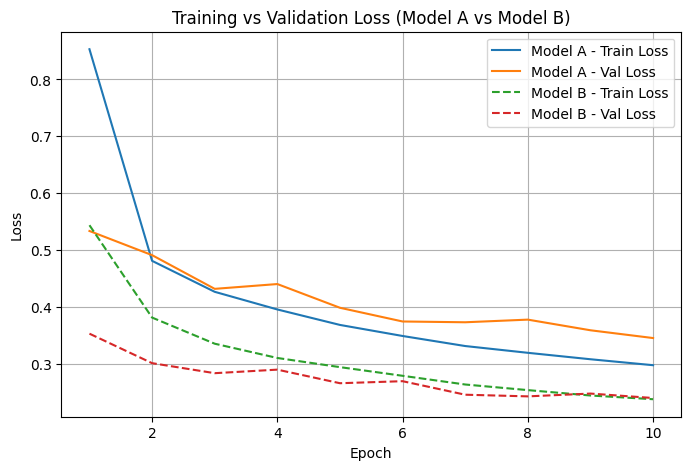

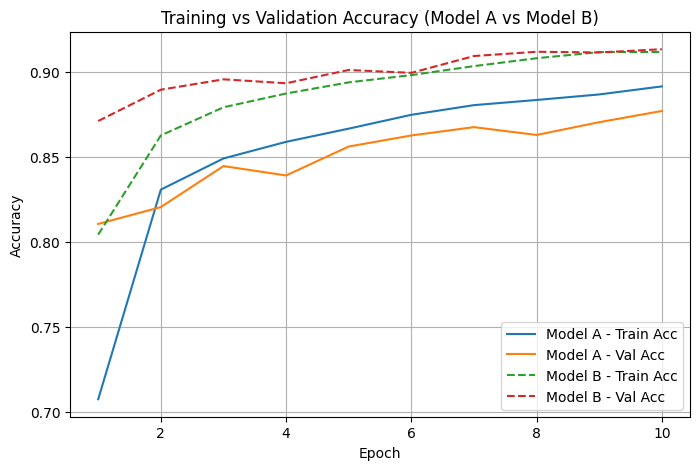

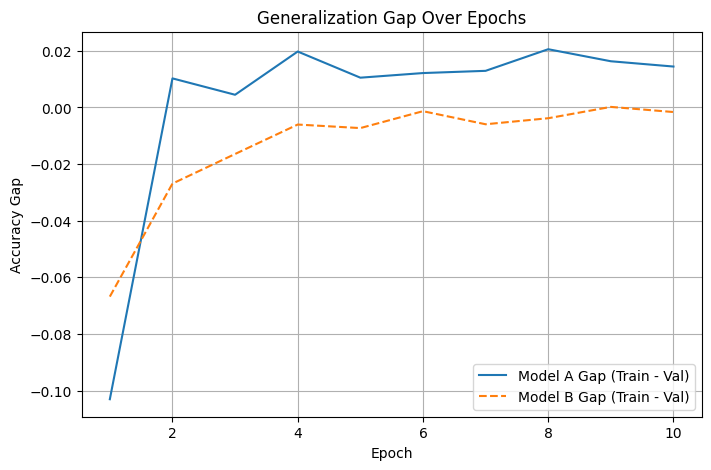


=== Final Epoch Summary ===
Model A - Train Loss: 0.2976, Train Acc: 0.8913
Model A - Val Loss  : 0.3453, Val Acc  : 0.8769
Model B - Train Loss: 0.2378, Train Acc: 0.9116
Model B - Val Loss  : 0.2399, Val Acc  : 0.9132

=== Final Generalization Gap (Train Acc - Val Acc) ===
Model A Gap: 0.0144
Model B Gap: -0.0016

=== High-level Interpretation (for your report, paraphrase as needed) ===
- Model B reaches higher validation accuracy than Model A.
- Model B has a smaller train–validation gap, indicating more robust generalization.

=== Baseline (no noise, on subset of validation) ===
Model A - Loss: 0.3563, Acc: 0.8742
Model B - Loss: 0.2551, Acc: 0.9083

Running robustness experiment (this may take a bit)...


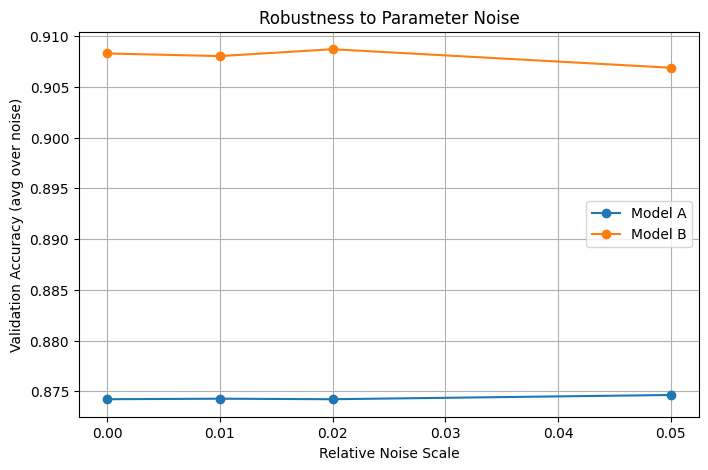


=== Robustness summary (higher is better) ===
Noise scale 0.000 | Model A acc: 0.8742 | Model B acc: 0.9083
Noise scale 0.010 | Model A acc: 0.8743 | Model B acc: 0.9080
Noise scale 0.020 | Model A acc: 0.8742 | Model B acc: 0.9087
Noise scale 0.050 | Model A acc: 0.8746 | Model B acc: 0.9069

(For the report, you can say: the model whose accuracy drops more slowly as we add noise
appears to sit in a more 'stable' or 'flatter' region of the loss landscape.)

Computing 1D loss slice around Model A...
Computing 1D loss slice around Model B...


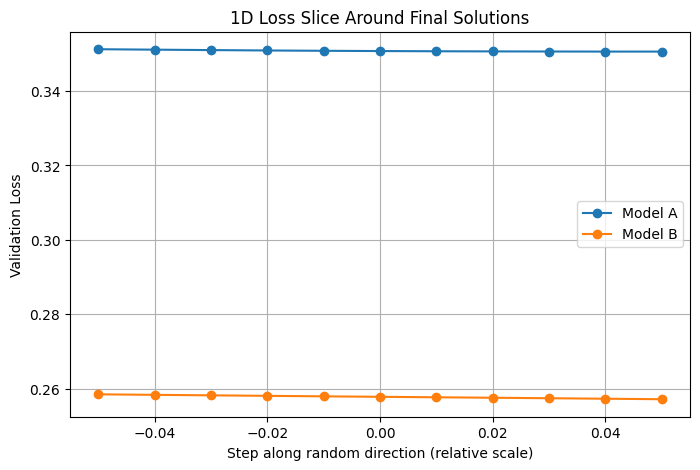


=== Interpretation hint for the report ===
- If one model's curve is much steeper (loss rises sharply as we move away),
  you can describe it as sitting in a 'sharper' region.
- If the other model's curve is flatter (loss changes more gently),
  you can describe it as sitting in a 'flatter' and more forgiving region.


In [5]:
# =========================================
# Script 3: Deeper Analysis & Visualization
# =========================================
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

# ---------- Load metrics ----------
df_a = pd.read_csv("results_model_a.csv")
df_b = pd.read_csv("results_model_b.csv")

print("Model A metrics (head):")
display(df_a.head())

print("Model B metrics (head):")
display(df_b.head())

# ---------- 1. Loss curves ----------
plt.figure(figsize=(8, 5))
plt.plot(df_a["epoch"], df_a["train_loss"], label="Model A - Train Loss")
plt.plot(df_a["epoch"], df_a["val_loss"], label="Model A - Val Loss")
plt.plot(df_b["epoch"], df_b["train_loss"], label="Model B - Train Loss", linestyle="--")
plt.plot(df_b["epoch"], df_b["val_loss"], label="Model B - Val Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Model A vs Model B)")
plt.legend()
plt.grid(True)
plt.show()

# ---------- 2. Accuracy curves ----------
plt.figure(figsize=(8, 5))
plt.plot(df_a["epoch"], df_a["train_acc"], label="Model A - Train Acc")
plt.plot(df_a["epoch"], df_a["val_acc"], label="Model A - Val Acc")
plt.plot(df_b["epoch"], df_b["train_acc"], label="Model B - Train Acc", linestyle="--")
plt.plot(df_b["epoch"], df_b["val_acc"], label="Model B - Val Acc", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (Model A vs Model B)")
plt.legend()
plt.grid(True)
plt.show()

# ---------- 3. Generalization gap over epochs ----------
df_a["gap"] = df_a["train_acc"] - df_a["val_acc"]
df_b["gap"] = df_b["train_acc"] - df_b["val_acc"]

plt.figure(figsize=(8, 5))
plt.plot(df_a["epoch"], df_a["gap"], label="Model A Gap (Train - Val)")
plt.plot(df_b["epoch"], df_b["gap"], label="Model B Gap (Train - Val)", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Gap")
plt.title("Generalization Gap Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# ---------- 4. Final numbers & simple summary ----------
final_a = df_a.iloc[-1]
final_b = df_b.iloc[-1]

print("\n=== Final Epoch Summary ===")
print(f"Model A - Train Loss: {final_a['train_loss']:.4f}, Train Acc: {final_a['train_acc']:.4f}")
print(f"Model A - Val Loss  : {final_a['val_loss']:.4f}, Val Acc  : {final_a['val_acc']:.4f}")
print(f"Model B - Train Loss: {final_b['train_loss']:.4f}, Train Acc: {final_b['train_acc']:.4f}")
print(f"Model B - Val Loss  : {final_b['val_loss']:.4f}, Val Acc  : {final_b['val_acc']:.4f}")

gap_a = final_a["gap"]
gap_b = final_b["gap"]

print("\n=== Final Generalization Gap (Train Acc - Val Acc) ===")
print(f"Model A Gap: {gap_a:.4f}")
print(f"Model B Gap: {gap_b:.4f}")

print("\n=== High-level Interpretation (for your report, paraphrase as needed) ===")
if final_b["val_acc"] > final_a["val_acc"]:
    print("- Model B reaches higher validation accuracy than Model A.")
else:
    print("- Model A and Model B reach similar validation accuracy in this run.")

if gap_b < gap_a:
    print("- Model B has a smaller train–validation gap, indicating more robust generalization.")
else:
    print("- The generalization gaps are similar; focus more on convergence speed and stability.")


# ============================================================
# 5. Parameter robustness: how sensitive is each model to noise?
#    (intuitive "flatness" / "sharpness" check)
# ============================================================

# Rebuild models and load weights
model_a = MLPModelA().to(device)
model_a.load_state_dict(torch.load("model_a.pth", map_location=device))

model_b = CNNModelB().to(device)
model_b.load_state_dict(torch.load("model_b.pth", map_location=device))

# Simple evaluation helper (no training)
def eval_model(model, loader, max_batches=None):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total += labels.size(0)
            if max_batches is not None and (i + 1) >= max_batches:
                break
    return total_loss / total, total_correct / total

# Flatten/unflatten utilities
def get_param_vector(model):
    return torch.cat([p.detach().flatten() for p in model.parameters()])

def set_param_vector(model, vec):
    pointer = 0
    for p in model.parameters():
        numel = p.numel()
        new_vals = vec[pointer:pointer+numel].view_as(p)
        p.data.copy_(new_vals)
        pointer += numel

# Baseline performance (no noise)
base_loss_a, base_acc_a = eval_model(model_a, val_loader, max_batches=50)
base_loss_b, base_acc_b = eval_model(model_b, val_loader, max_batches=50)
print("\n=== Baseline (no noise, on subset of validation) ===")
print(f"Model A - Loss: {base_loss_a:.4f}, Acc: {base_acc_a:.4f}")
print(f"Model B - Loss: {base_loss_b:.4f}, Acc: {base_acc_b:.4f}")

# Noise experiment
noise_scales = [0.0, 0.01, 0.02, 0.05]  # relative to parameter norm
num_samples_per_scale = 3

def robustness_curve(model, loader, noise_scales, num_samples=3, max_batches=50):
    base_vec = get_param_vector(model)
    base_norm = base_vec.norm()
    accs = []

    for s in noise_scales:
        acc_list = []
        for _ in range(num_samples):
            if s == 0.0:
                # no noise, just evaluate baseline
                set_param_vector(model, base_vec)
            else:
                noise = torch.randn_like(base_vec)
                noise = noise / noise.norm() * (s * base_norm)
                new_vec = base_vec + noise
                set_param_vector(model, new_vec)
            _, acc = eval_model(model, loader, max_batches=max_batches)
            acc_list.append(acc)
        accs.append(np.mean(acc_list))
        # restore original parameters
        set_param_vector(model, base_vec)
    return accs

print("\nRunning robustness experiment (this may take a bit)...")
robust_acc_a = robustness_curve(model_a, val_loader, noise_scales)
robust_acc_b = robustness_curve(model_b, val_loader, noise_scales)

plt.figure(figsize=(8, 5))
plt.plot(noise_scales, robust_acc_a, marker="o", label="Model A")
plt.plot(noise_scales, robust_acc_b, marker="o", label="Model B")
plt.xlabel("Relative Noise Scale")
plt.ylabel("Validation Accuracy (avg over noise)")
plt.title("Robustness to Parameter Noise")
plt.legend()
plt.grid(True)
plt.show()

print("\n=== Robustness summary (higher is better) ===")
for s, a_acc, b_acc in zip(noise_scales, robust_acc_a, robust_acc_b):
    print(f"Noise scale {s:.3f} | Model A acc: {a_acc:.4f} | Model B acc: {b_acc:.4f}")

print("\n(For the report, you can say: the model whose accuracy drops more slowly as we add noise")
print("appears to sit in a more 'stable' or 'flatter' region of the loss landscape.)")


# ============================================================
# 6. 1D loss slice around each model along a random direction
#    (very simple 'loss landscape cut' visualization)
# ============================================================

def loss_slice_1d(model, loader, alpha_values, max_batches=30):
    base_vec = get_param_vector(model)
    base_norm = base_vec.norm()
    # random direction
    direction = torch.randn_like(base_vec)
    direction = direction / direction.norm() * base_norm  # same scale as params

    losses = []
    for a in alpha_values:
        new_vec = base_vec + a * direction
        set_param_vector(model, new_vec)
        loss, _ = eval_model(model, loader, max_batches=max_batches)
        losses.append(loss)

    # restore
    set_param_vector(model, base_vec)
    return losses

alpha_vals = np.linspace(-0.05, 0.05, 11)  # perturb up to ±5% along a random direction

print("\nComputing 1D loss slice around Model A...")
losses_a_slice = loss_slice_1d(model_a, val_loader, alpha_vals)

print("Computing 1D loss slice around Model B...")
losses_b_slice = loss_slice_1d(model_b, val_loader, alpha_vals)

plt.figure(figsize=(8, 5))
plt.plot(alpha_vals, losses_a_slice, marker="o", label="Model A")
plt.plot(alpha_vals, losses_b_slice, marker="o", label="Model B")
plt.xlabel("Step along random direction (relative scale)")
plt.ylabel("Validation Loss")
plt.title("1D Loss Slice Around Final Solutions")
plt.legend()
plt.grid(True)
plt.show()

print("\n=== Interpretation hint for the report ===")
print("- If one model's curve is much steeper (loss rises sharply as we move away),")
print("  you can describe it as sitting in a 'sharper' region.")
print("- If the other model's curve is flatter (loss changes more gently),")
print("  you can describe it as sitting in a 'flatter' and more forgiving region.")
